Assignment 3
=============
<span style="color: lightsteelblue;">Udacity university | Deep Learning</span>

Previously in `assignment_2.ipynb`, we trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

In [55]:
# Custom libraries

# To plot charts
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

## Solution to problem 2

Let's start playing. We start with logistic model and then move on to deep network.

### Logistic model

First we tweak the loss by adding Euclidean norm.

Below we override `loss` function keeping `original_loss` intact.

### Neural network

The same here - we tweak the loss by adding Euclidean norm.

Below we override `loss` function keeping `original_loss` intact.

In [51]:
batch_size = 128
num_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)
  
  # Hidden layer variables
  hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_nodes]))
  hidden_biases = tf.Variable(tf.zeros([num_nodes]))

  # Variables
  weights = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  hidden_layer_train = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
  logits = tf.matmul(hidden_layer_train, weights) + biases
  original_loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  loss = original_loss + beta * (tf.nn.l2_loss(weights) + tf.nn.l2_loss(hidden_weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)

  hidden_layer_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
  valid_prediction = tf.nn.softmax(
    tf.matmul(hidden_layer_valid, weights) + biases)

  hidden_layer_test= tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
  test_prediction = tf.nn.softmax(
    tf.matmul(hidden_layer_test, weights) + biases)

And see how new `loss` function works:

In [52]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]

    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta: 0.001}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)

    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 667.363647
Minibatch accuracy: 9.4%
Validation accuracy: 26.7%
Minibatch loss at step 500: 201.127304
Minibatch accuracy: 78.1%
Validation accuracy: 80.5%
Minibatch loss at step 1000: 116.982765
Minibatch accuracy: 79.7%
Validation accuracy: 81.8%
Minibatch loss at step 1500: 68.475349
Minibatch accuracy: 91.4%
Validation accuracy: 82.9%
Minibatch loss at step 2000: 41.329937
Minibatch accuracy: 89.8%
Validation accuracy: 84.9%
Minibatch loss at step 2500: 25.155510
Minibatch accuracy: 89.8%
Validation accuracy: 86.0%
Minibatch loss at step 3000: 15.517172
Minibatch accuracy: 86.7%
Validation accuracy: 86.6%
Test accuracy: 93.2%


You see? Geee, the accuracy is astonishing :)

Let us find the best `beta`.

In [78]:
num_steps = 1501
beta_values_to_try = [pow(10, i) for i in np.arange(-2.4, -1.8, 0.1)]
accuracies = []

for beta_value in beta_values_to_try:
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]

      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta: beta_value}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    accuracies.append(accuracy(test_prediction.eval(), test_labels))

Initialized
Initialized
Initialized
Initialized
Initialized
Initialized


[92.060000000000002, 91.540000000000006, 91.290000000000006, 90.819999999999993, 90.609999999999999, 90.030000000000001] [0.0039810717055349734, 0.0050118723362727246, 0.0063095734448019363, 0.0079432823472428207, 0.010000000000000011, 0.012589254117941687]


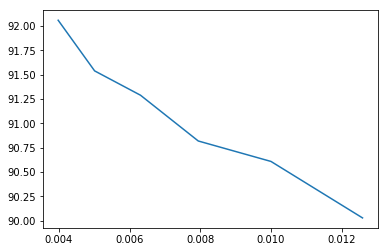

In [79]:
print(accuracies, beta_values_to_try)
plt.plot(beta_values_to_try, accuracies)
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
